<a href="https://colab.research.google.com/github/balawillgetyou/dy/blob/master/StateFarmDistractedDriverDetection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#Download kaggle.json from Kaggle -- MyAccount -- Create New API Token - auto downloads as "kaggle.json
#Import json into notebook - run in a cell 
from google.colab import files
files.upload()

#Browse to downloaded kaggle.json and upload

In [ ]:
#Setup Kaggle DIR; copy json file ; chmod
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
!ls ~/.kaggle

kaggle.json


In [ ]:
#Verify json content
!ls -l ~/.kaggle
!cat ~/.kaggle/kaggle.json

In [ ]:
#Install kaggle packages
!pip install -q kaggle

In [ ]:
!kaggle competitions download -c state-farm-distracted-driver-detection

100% 4.00G/4.00G [00:59<00:00, 124MB/s]
100% 4.00G/4.00G [00:59<00:00, 71.9MB/s]


In [ ]:
import os
os.chdir('/content')
!ls -d $PWD/*

/content/kaggle.json  /content/state-farm-distracted-driver-detection.zip
/content/sample_data


In [ ]:
import zipfile
zip_ref = zipfile.ZipFile('state-farm-distracted-driver-detection.zip', 'r')
zip_ref.extractall()
zip_ref.close()

In [ ]:
train_dir = "imgs/train"
train_class=os.listdir(train_dir)
print(train_class)

test_dir = "imgs/test"
test_class=train_class
print(test_class)

['c7', 'c9', 'c5', 'c6', 'c0', 'c2', 'c1', 'c8', 'c4', 'c3']
['c7', 'c9', 'c5', 'c6', 'c0', 'c2', 'c1', 'c8', 'c4', 'c3']


In [ ]:
#creating useful labels
classes = ('Safe driving', 
           'Texting - right', 
           'Talking on the phone - right', 
           'Texting - left', 
           'Talking on the phone - left', 
           'Operating the radio', 
           'Drinking', 
           'Reaching behind', 
           'Hair and makeup', 
           'Talking to passenger')

In [ ]:
#number of files across all sub folders
!find . -type f | wc -l

102173


In [1]:
import itertools
import numpy as np
import random
import matplotlib.pyplot as plt
import cv2
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
import os
import warnings
warnings.filterwarnings('ignore')

import torch
import torch.nn.functional as F
from torch import nn
from torchvision import datasets, transforms, models
import torch.utils.data as data_utils

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Image transformations and preview

In [ ]:
def im_convert(tensor):
    image = tensor.to("cpu").clone().detach()
    image = image.numpy().squeeze()
    image = image.transpose(1,2,0)
    image = image * np.array((0.5, 0.5, 0.5)) + np.array((0.5, 0.5, 0.5))
    image = image.clip(0, 1)
    return image

In [ ]:
transform = transforms.Compose([transforms.Resize((224,224)),
                               transforms.ToTensor(),
                               transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])#refer https://pytorch.org/hub/pytorch_vision_vgg/
                               ])

training_dataset = datasets.ImageFolder('imgs/train', transform=transform)

train_size = int(0.8 * len(training_dataset))
test_size = len(training_dataset) - train_size
train_dataset, test_dataset = torch.utils.data.random_split(training_dataset, [train_size, test_size])
training_loader = torch.utils.data.DataLoader(train_dataset, batch_size=128, shuffle=True)
validation_loader = torch.utils.data.DataLoader(test_dataset, batch_size=128, shuffle=False)

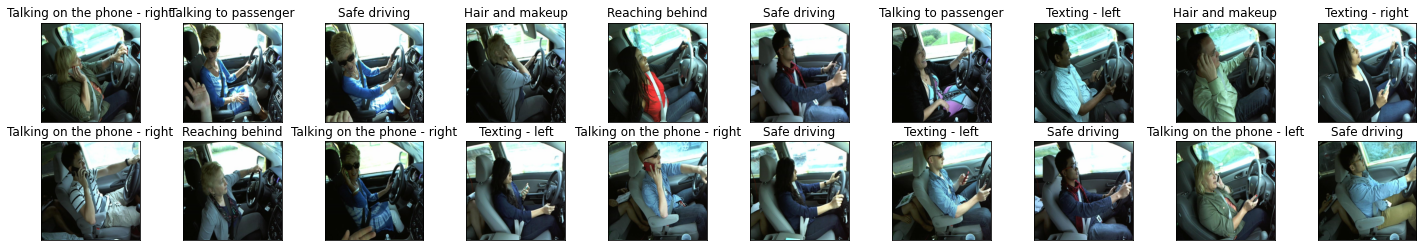

In [ ]:
dataiter = iter(training_loader)
images, labels = dataiter.next()
fig = plt.figure(figsize=(25, 4))

for idx in np.arange(20):
  ax = fig.add_subplot(2, 10, idx+1, xticks=[], yticks=[])
  plt.imshow(im_convert(images[idx]))
  ax.set_title(classes[labels[idx].item()])

# Loading the pre-trained VGG-19 model, retraining the classifier alone  
The VGG model is trained on 1+ million images to classify into 1,000 classes. We need to re-use the feature extracting convolutional layers and retrain only the last classifying layer for our needs.

In [3]:
model = models.vgg16(pretrained=True)
for param in model.parameters():
  param.requires_grad_(False)#to not retrain the CNN/ feature extraction part

### The architecture of the pretrained VGG models is as below.   
Source: PyTorch documentation  
![VGG-NETS](https://pytorch.org/assets/images/vgg.png)

In [ ]:
#modifying the last layer alone from the pretrained VGG19 model. # of inputs to the last layer remain the same
#model.classifier[6] is the current last layer, pretrained to classify into 1,000 classes, but we need to classify to 10 classes
n_inputs = model.classifier[6].in_features
last_layer = nn.Linear(n_inputs, len(classes))
model.classifier[6] = last_layer
model.to(device)
print(model.classifier[6].out_features)

10


In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr = 0.0001)

In [ ]:
epochs = 5
running_loss_history = []
running_corrects_history = []
val_running_loss_history = []
val_running_corrects_history = []
#for final scoring
val_labels_list = []
val_preds_list = []

for e in range(epochs):
  
  running_loss = 0.0
  running_corrects = 0.0
  val_running_loss = 0.0
  val_running_corrects = 0.0
  
  for inputs, labels in training_loader:
    inputs = inputs.to(device)
    labels = labels.to(device)
    outputs = model(inputs)
    loss = criterion(outputs, labels)
    
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    _, preds = torch.max(outputs, 1)
    running_loss += loss.item()
    running_corrects += torch.sum(preds == labels.data)

  else:
    with torch.no_grad():
      for val_inputs, val_labels in validation_loader:
        val_inputs = val_inputs.to(device)
        val_labels = val_labels.to(device)
        val_outputs = model(val_inputs)
        val_loss = criterion(val_outputs, val_labels)
        
        _, val_preds = torch.max(val_outputs, 1)
        val_running_loss += val_loss.item()
        val_running_corrects += torch.sum(val_preds == val_labels.data)
      
    epoch_loss = running_loss/len(training_loader.dataset)
    epoch_acc = running_corrects.float()/ len(training_loader.dataset)
    running_loss_history.append(epoch_loss)
    running_corrects_history.append(epoch_acc)
    
    val_epoch_loss = val_running_loss/len(validation_loader.dataset)
    val_epoch_acc = val_running_corrects.float()/ len(validation_loader.dataset)
    val_running_loss_history.append(val_epoch_loss)
    val_running_corrects_history.append(val_epoch_acc)
    print('epoch :', (e+1))
    print('training loss: {:.4f}, acc {:.4f} '.format(epoch_loss, epoch_acc.item()))
    print('validation loss: {:.4f}, validation acc {:.4f} '.format(val_epoch_loss, val_epoch_acc.item()))

    #scoring
    val_labels_list.append(val_labels)
    val_preds_list.append(val_preds)
    preds_list_processed = [x.to("cpu").numpy() for x in val_preds_list]
    labels_list_processed = [x.to("cpu").numpy() for x in val_labels_list]

    preds_list_processed = list(itertools.chain.from_iterable(preds_list_processed))
    labels_list_processed = list(itertools.chain.from_iterable(labels_list_processed))

epoch : 1
training loss: 0.0036, acc 0.8575 
validation loss: 0.0006, validation acc 0.9819 
epoch : 2
training loss: 0.0002, acc 0.9913 
validation loss: 0.0003, validation acc 0.9911 
epoch : 3
training loss: 0.0001, acc 0.9966 
validation loss: 0.0002, validation acc 0.9924 
epoch : 4
training loss: 0.0000, acc 0.9986 
validation loss: 0.0002, validation acc 0.9940 
epoch : 5
training loss: 0.0001, acc 0.9965 
validation loss: 0.0003, validation acc 0.9906 


In [ ]:
print(classification_report(labels_list_processed, preds_list_processed, target_names=classes))

                              precision    recall  f1-score   support

                Safe driving       0.98      0.99      0.98       484
             Texting - right       1.00      1.00      1.00       443
Talking on the phone - right       1.00      0.99      1.00       457
              Texting - left       1.00      0.98      0.99       487
 Talking on the phone - left       0.99      0.99      0.99       454
         Operating the radio       1.00      0.99      0.99       466
                    Drinking       0.99      1.00      0.99       479
             Reaching behind       0.99      0.99      0.99       386
             Hair and makeup       0.94      0.99      0.96       377
        Talking to passenger       1.00      0.96      0.98       452

                    accuracy                           0.99      4485
                   macro avg       0.99      0.99      0.99      4485
                weighted avg       0.99      0.99      0.99      4485



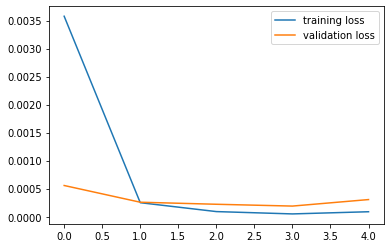

In [ ]:
plt.plot(running_loss_history, label='training loss')
plt.plot(val_running_loss_history, label='validation loss')
plt.legend()

In [ ]:
torch.save(model.state_dict(), 'distractedDriversPyTorch_Val.pth')
files.download('distractedDriversPyTorch_Val.pth')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>